In [1]:
import torch
import requests
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
import numpy as np
import matplotlib.pyplot as plt

In [2]:
url= "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response= requests.get(url)
text= response.text

print(f"Length of text: {len(text)}")
print("First 500 Chars: ")
print(text[:500])

Length of text: 1115394
First 500 Chars: 
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [3]:
chars= sorted(list(set(text)))
vocab_size= len(chars)
print(''.join(chars))
print(f"Vocabulary size: {vocab_size}")


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocabulary size: 65


In [4]:
# Create mapping from chars to int (and vice-versa)
stoi= { ch:i for i,ch in enumerate(chars) }
itos= { i:ch for i, ch in enumerate(chars) }

encode= lambda s: [stoi[c] for c in s] # encoder: take a string and output a list of ints
decode= lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("Hello"))
print(decode(encode("Hello")))

[20, 43, 50, 50, 53]
Hello


In [5]:
# Encode entire text into a torch.Tensor to form a dataset
data= torch.tensor(encode(text), dtype= torch.long)
print(f"Data tensor shape: {data.shape}")

n= int(0.9 * len(data))
train_data= data[:n]
val_data= data[n:]

Data tensor shape: torch.Size([1115394])


In [6]:
torch.manual_seed(42)
batch_size= 4
block_size= 8 # Maximum context length for preds

def get_batch(split, block_size, batch_size):
    # Generate small batch of data of inputs x and targs y
    data= train_data if split == 'train' else val_data
    ix= torch.randint(len(data) - block_size, (batch_size,)) # Random starting indices
    x= torch.stack([data[i : i+block_size] for i in ix])
    y= torch.stack([data[i+1 : i+block_size+1] for i in ix])
    return x, y

# Testing batch creation
xb, yb= get_batch('train', block_size, batch_size)
print('Inputs(x): ')
print(xb.shape)
print(xb)
print('\nTargets (y):')
print(yb.shape)
print(yb)
print('\n--- For Context ---')
for b in range(batch_size):
    context= xb[b]
    target= yb[b]
    print(f"When input is '{decode(context.tolist())}', target is '{decode(target.tolist())}'")


Inputs(x): 
torch.Size([4, 8])
tensor([[57,  1, 46, 47, 57,  1, 50, 53],
        [ 1, 58, 46, 43, 56, 43,  1, 41],
        [17, 26, 15, 17, 10,  0, 32, 53],
        [57, 58,  6,  1, 61, 47, 58, 46]])

Targets (y):
torch.Size([4, 8])
tensor([[ 1, 46, 47, 57,  1, 50, 53, 60],
        [58, 46, 43, 56, 43,  1, 41, 39],
        [26, 15, 17, 10,  0, 32, 53,  1],
        [58,  6,  1, 61, 47, 58, 46,  0]])

--- For Context ---
When input is 's his lo', target is ' his lov'
When input is ' there c', target is 'there ca'
When input is 'ENCE:
To', target is 'NCE:
To '
When input is 'st, with', target is 't, with
'


In [7]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, cell_type= 'lstm', dropout_rate= 0.5):
        super().__init__()
        self.cell_type= cell_type.lower()
        self.hidden_dim= hidden_dim
        self.num_layers= num_layers

        # Layers
        self.embedding= nn.Embedding(vocab_size, embedding_dim)
        # Choose type of network (RNN / LSTM)
        if self.cell_type == 'lstm':
            self.rnn= nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout= dropout_rate, batch_first= True)
        elif self.cell_type == 'rnn':
            self.rnn= nn.RNN(embedding_dim, hidden_dim, num_layers, dropout= dropout_rate, batch_first= True)
        else:
            raise ValueError("cell_type must be 'rnn' or 'lstm'")

        self.dropout= nn.Dropout(dropout_rate)
        self.fc= nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden= None):
        emb= self.dropout(self.embedding(x))
        rnn_out, hidden= self.rnn(emb, hidden)
        out= self.dropout(rnn_out)
        logits= self.fc(out)
        return logits, hidden

    def init_hidden(self, batch_size, device= torch.device('cpu')):
        weight= next(self.parameters())
        # Initializing hidden state/cell state weights to all zeros as per theory
        if self.cell_type == 'lstm':
            h= weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)
            c= weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)
            return (h, c)
        else:
            # RNN has no cell state so its just the hidden state being returned here
            return weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)

In [8]:
def compute_norm(tensor):
    if isinstance(tensor, (list, tuple)):
        return [compute_norm(t) for t in tensor]
    else:
        return tensor.norm().item()

In [9]:
@torch.no_grad()
def estimate_metrics(model, block_size, batch_size, split, eval_iters, device= 'cpu'):
    model.eval()
    losses= []
    activation_norms= []
    correct_predictions= []
    total_predictions= []

    for _ in range(eval_iters):
        xb, yb= get_batch(split, block_size, batch_size)
        xb, yb= xb.to(device), yb.to(device)

        hidden= model.init_hidden(batch_size, device)
        logits, hidden= model(xb, hidden)

        # Calculating loss
        loss= F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
        losses.append(loss.item())

        # Calculating accuracy
        predictions= torch.argmax(logits, dim= -1)
        correct= (predictions == yb).sum().item()
        total= yb.numel()

        correct_predictions.append(correct)
        total_predictions.append(total)

        if hasattr(model, 'cell_type') and model.cell_type ==' lstm':
            act_norm= compute_norm(hidden[0])
        else:
            act_norm= compute_norm(hidden)
        activation_norms.append(act_norm)
    avg_loss= np.mean(losses)
    avg_act_norm= np.mean(activation_norms)
    accuracy= (np.sum(correct_predictions) / np.sum(total_predictions)) * 100
    model.train()

    return avg_loss, accuracy, avg_act_norm

In [10]:

def train_model(model_type,
                block_size,
                num_iters= 1000,
                batch_size= 32,
                eval_interval= 100,
                eval_iters= 50,
                embedding_dim= 128,
                hidden_dim= 512,
                num_layers= 3,
                learning_rate= 0.001,
                optimizer= 'adam',
                device= 'cpu'):

    model= CharRNN(vocab_size, embedding_dim, hidden_dim, num_layers, cell_type= model_type).to(device)
    if optimizer.lower() == 'adam':
        optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate)
    elif optimizer.lower() == 'sgd':
        optimizer= torch.optim.SGD(model.parameters(), lr= learning_rate, momentum= 0.9)
    else:
        raise ValueError(f"Supported optimizers are only Adam and SGD")

    # Track per-batch metrics for detailed analysis
    raw_train_losses= []
    raw_grad_norms= []

    # Tracking averaged metrics for fair comparison with validation
    avg_train_losses= []
    avg_train_act_norms= []
    train_accuracies= []
    val_accuracies= []
    val_losses= []
    val_act_norms= []
    eval_points= [] # Tracking when evals happened

    # Early stopping vars
    best_val_accuracy= 0
    min_delta= 0.1
    patience= 3
    epochs_with_no_improvement= 0

    for iter in range(num_iters):
        xb, yb= get_batch('train', block_size, batch_size)
        xb, yb= xb.to(device), yb.to(device)

        optimizer.zero_grad()

        hidden= model.init_hidden(batch_size, device)
        logits, hidden= model(xb, hidden)
        loss= F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))


        loss.backward()

        # Compute gradient norms for all params in RNN layer
        total_grad_norm= 0
        for name, param in model.named_parameters():
            if param.grad is not None and 'rnn' in name:
                total_grad_norm+= param.grad.norm().item()

        optimizer.step()

        raw_train_losses.append(loss.item())
        raw_grad_norms.append(total_grad_norm)

        # Eval Step
        if iter % eval_interval == 0 or iter == num_iters - 1:
            # Estimate average train loss and activation norm
            train_loss, train_accuracy, train_act_norm= estimate_metrics(model, block_size, batch_size, 'train', eval_iters, device)
            # Estimate validation loss and activation norm
            val_loss, val_accuracy, val_act_norm= estimate_metrics(model, block_size, batch_size, 'val', eval_iters, device)

            avg_train_losses.append(train_loss)
            avg_train_act_norms.append(train_act_norm)
            val_losses.append(val_loss)
            val_act_norms.append(val_act_norm)
            eval_points.append(iter)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            print(f"Iter {iter}:")
            print(f"-"*30)
            print(f"Avg Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},")
            print(f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%"),
            print(f"Avg Train Act Norm: {train_act_norm:.4f}, Val Act Norm: {val_act_norm:.4f},")
            print(f"GradNorm {total_grad_norm:.4f}")
            print("-"*50)

            if best_val_accuracy + min_delta <= val_accuracy:
              best_val_accuracy= val_accuracy
              epochs_with_no_improvement= 0
            else:
              epochs_with_no_improvement+= 1
            if epochs_with_no_improvement >= patience:
              print(f"Early stopping triggered at iter: {iter}. No improvement in {patience} eval intervals")
              break
    metrics= {
        'raw_train_losses': raw_train_losses,
        'avg_train_losses': avg_train_losses,
        'train_accuracies': train_accuracies,
        'avg_train_act_norms': avg_train_act_norms,
        'raw_grad_norms': raw_grad_norms,
        'val_losses': val_losses,
        'val_act_norms': val_act_norms,
        'val_accuracies': val_accuracies,
        'eval_points': eval_points
    }
    return model, metrics


In [11]:
torch.manual_seed(42)
results = {}
block_sizes = [128, 256]
model_types = ['rnn', 'lstm']
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for bs in block_sizes:
    for mt in model_types:
        print(f"\n=== Training {mt.upper()} with block_size {bs} ===")
        key = f"{mt}_bs{bs}"
        results[key] = train_model(model_type= mt, block_size= bs, num_iters=20000, eval_interval=1000, device= device)


=== Training RNN with block_size 128 ===
Iter 0:
------------------------------
Avg Train Loss: 3.8716, Val Loss: 3.8790,
Train Accuracy: 17.57%, Val Accuracy: 17.00%
Avg Train Act Norm: 56.3546, Val Act Norm: 56.3010,
GradNorm 1.6655
--------------------------------------------------
Iter 1000:
------------------------------
Avg Train Loss: 1.6799, Val Loss: 1.8263,
Train Accuracy: 50.01%, Val Accuracy: 45.77%
Avg Train Act Norm: 198.4045, Val Act Norm: 198.4902,
GradNorm 0.6042
--------------------------------------------------
Iter 2000:
------------------------------
Avg Train Loss: 1.5850, Val Loss: 1.7356,
Train Accuracy: 52.43%, Val Accuracy: 48.60%
Avg Train Act Norm: 205.5076, Val Act Norm: 205.2169,
GradNorm 0.5363
--------------------------------------------------
Iter 3000:
------------------------------
Avg Train Loss: 1.5398, Val Loss: 1.7036,
Train Accuracy: 53.45%, Val Accuracy: 49.15%
Avg Train Act Norm: 208.2188, Val Act Norm: 207.9402,
GradNorm 0.5283
--------------

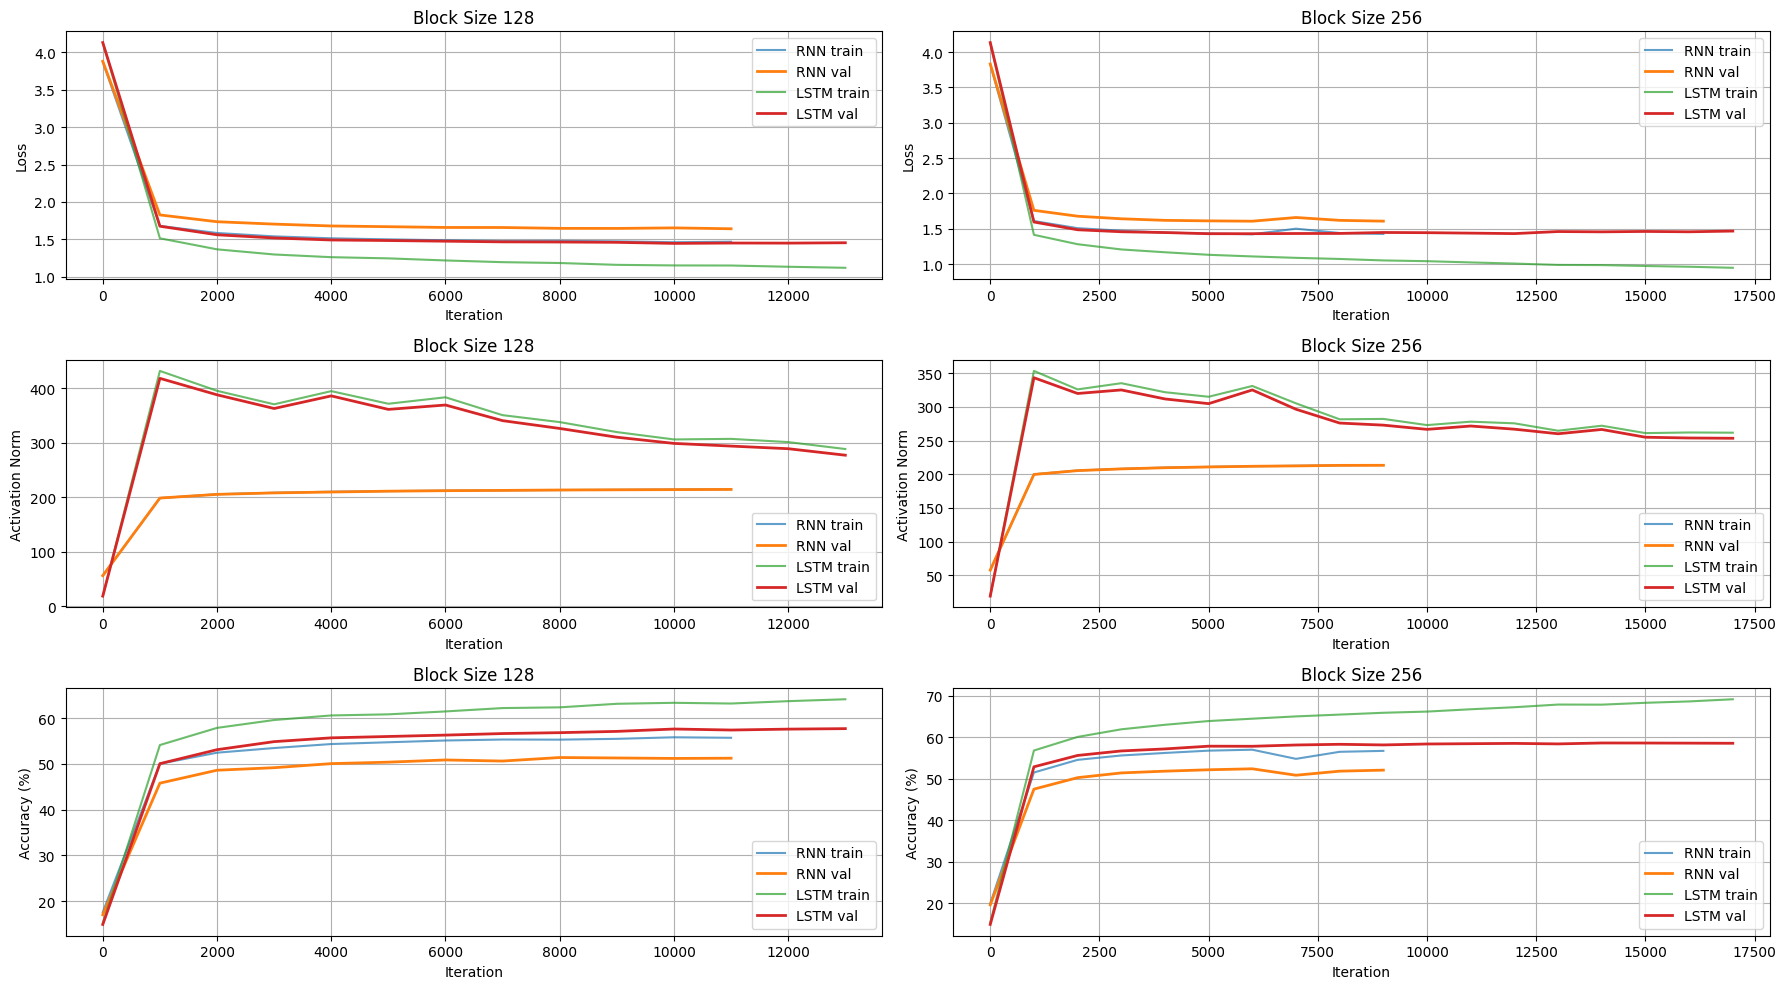

In [12]:
# Plot results
fig, axes = plt.subplots(3, 2, figsize=(18, 10))

# Plot training and validation loss
for i, bs in enumerate(block_sizes):
    for mt in model_types:
        key = f"{mt}_bs{bs}"
        _, data = results[key]
        axes[0, i].plot(data['eval_points'], data['avg_train_losses'], label=f'{mt.upper()} train', alpha=0.7)
        axes[0, i].plot(data['eval_points'], data['val_losses'], label=f'{mt.upper()} val', linewidth=2)
    axes[0, i].set_title(f'Block Size {bs}')
    axes[0, i].set_xlabel('Iteration')
    axes[0, i].set_ylabel('Loss')
    axes[0, i].legend()
    axes[0, i].grid(True)

# Plot activation norms
for i, bs in enumerate(block_sizes):
    for mt in model_types:
        key = f"{mt}_bs{bs}"
        _, data = results[key]
        axes[1, i].plot(data['eval_points'], data['avg_train_act_norms'], label=f'{mt.upper()} train', alpha=0.7)
        axes[1, i].plot(data['eval_points'], data['val_act_norms'], label=f'{mt.upper()} val', linewidth=2)
    axes[1, i].set_title(f'Block Size {bs}')
    axes[1, i].set_xlabel('Iteration')
    axes[1, i].set_ylabel('Activation Norm')
    axes[1, i].legend()
    axes[1, i].grid(True)
for i, bs in enumerate(block_sizes):
    for mt in model_types:
        key = f"{mt}_bs{bs}"
        _, data = results[key]
        axes[2, i].plot(data['eval_points'], data['train_accuracies'], label=f'{mt.upper()} train', alpha=0.7)
        axes[2, i].plot(data['eval_points'], data['val_accuracies'], label=f'{mt.upper()} val', linewidth=2)
    axes[2, i].set_title(f'Block Size {bs}')
    axes[2, i].set_xlabel('Iteration')
    axes[2, i].set_ylabel('Accuracy (%)')
    axes[2, i].legend()
    axes[2, i].grid(True)

plt.tight_layout()
plt.show()



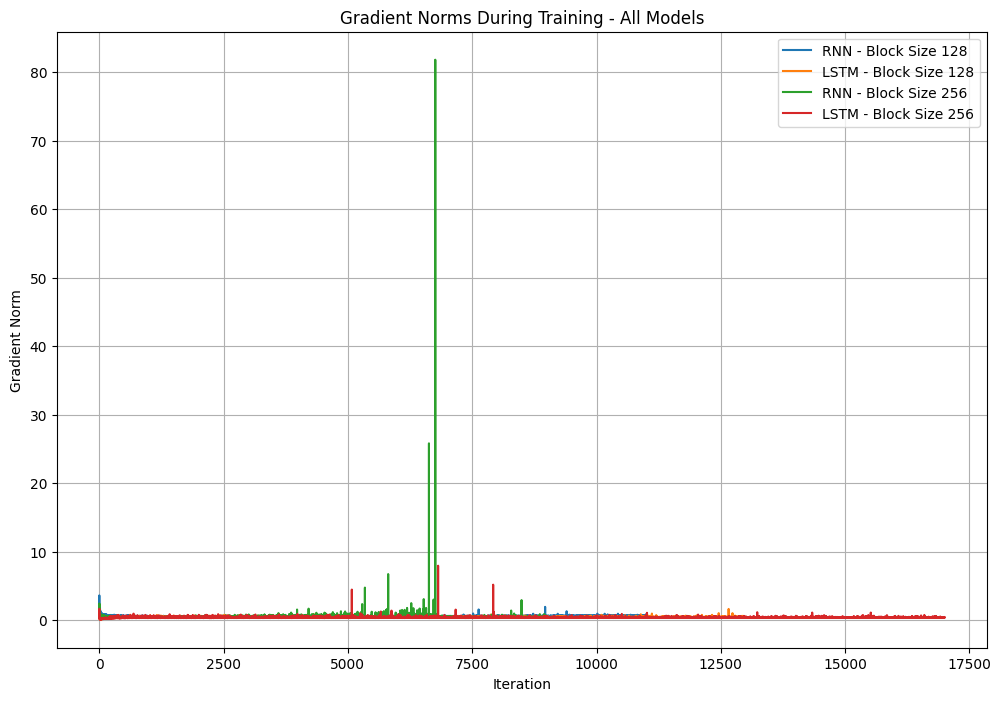

In [13]:
# Plot all gradient norms on a single plot for comparison
plt.figure(figsize=(12, 8))

for bs in block_sizes:
    for mt in model_types:
        key = f"{mt}_bs{bs}"
        model, data = results[key]  # Unpack the tuple to get the metrics data
        plt.plot(data['raw_grad_norms'], label=f'{mt.upper()} - Block Size {bs}')

plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms During Training - All Models')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
def generate_text(model, start_string, num_chars=1000, temperature=0.8, device='cpu'):

    model.eval()

    # Convert starting string to tensor
    chars = encode(start_string)
    input_tensor = torch.tensor(chars, dtype=torch.long).unsqueeze(0).to(device)

    # Initialize hidden state
    hidden = model.init_hidden(1, device)

    # If we have an LSTM, we need to handle the tuple
    if hasattr(model, 'cell_type') and model.cell_type == 'lstm':
        # For LSTM: hidden is (h, c)
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    else:
        # For RNN: just detach the hidden state
        hidden = hidden.detach()

    # Generate characters
    generated_chars = list(chars)

    with torch.no_grad():
        for i in range(num_chars):
            # Forward pass
            output, hidden = model(input_tensor, hidden)

            # Get last prediction
            logits = output[:, -1, :] / temperature
            probabilities = F.softmax(logits, dim=-1)

            # Sample from the distribution
            predicted_id = torch.multinomial(probabilities, 1).item()

            # Add to sequence and prepare next input
            generated_chars.append(predicted_id)
            input_tensor = torch.tensor([[predicted_id]], dtype=torch.long).to(device)

            # Update hidden state for next iteration
            if hasattr(model, 'cell_type') and model.cell_type == 'lstm':
                h, c = hidden
                h = h.detach()
                c = c.detach()
                hidden = (h, c)
            else:
                hidden = hidden.detach()

    # Decode the generated characters
    return decode(generated_chars)

In [15]:
# Let's generate text from each of your trained models
for bs in block_sizes:
    for mt in model_types:
        key = f"{mt}_bs{bs}"
        model, metrics = results[key]  # Unpack the tuple

        print(f"\n=== {mt.upper()} with block_size {bs} ===")
        print("Generated text:")

        # Generate text starting with a common Shakespearean phrase
        generated_text = generate_text(
            model,
            start_string="First Citizen:",
            num_chars=500,
            temperature=0.8,
            device=device
        )

        print(generated_text)
        print("-" * 80)


=== RNN with block_size 128 ===
Generated text:
First Citizen:
I have be douth up not say and vow, and
I't ever my life, here well in enemies my grave,
The marriage
To wins of them fair say see the courous son of remain of his cucion.

BRUTUS:
My more death.

ROMEO:
No more in my stard of the sing to the greater to do it strawn, provo full.

First Citizen:
I have dead have thee, bewine anger to you?

LUCIO:
Which should never dead now the death as that was a heaving many lord,
And is nor to every lord;
Look in person to be revenge him, and with soffer my l
--------------------------------------------------------------------------------

=== LSTM with block_size 128 ===
Generated text:
First Citizen:
Who will not have the garden of his protection say
you?

ROMEO:
There is no son that is so noble complected
To cross your majesty.

CORIOLANUS:
No, my lord; so fear'd himself, stay here not,
And in this mock of love to do them have
When my dangerous world of an estate villain swear
How the